<a href="https://colab.research.google.com/github/patimus-prime/ML_notebooks/blob/master/high_throughput_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
 # # Next few cells get all libraies/mount google drive for data

# !pip install -q condacolab # for getting conda packages
# !pip install -q colabcode #opens a default VSCode on web, optional if additional scripts; else Colab is fine.
# !pip install --quiet pytorch-lightning datetime # will install torch automatically

# import condacolab
# condacolab.install()
# # THE KERNEL/COLAB SESSION WILL BE RESTARTED/report crash. NORMAL

In [96]:
# # AFTER RESTART, RUN THIS CELL TO BE SURE A-OK. THEN RUN ALL AGAIN.
# import condacolab
# condacolab.check() # should see cake

<img src="https://i.imgflip.com/6xaidw.jpg" width="300" height="400" />

So, this seemed fairly straightforward but actually, it was not. Let's get into it!

In [97]:
# mount the google drive, one can alternatively upload manually.
# path is specified below for pandas upload
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import data!

In [98]:
import pandas as pd
import sys as sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# these should also be pre-installed in colab, can use condacolab above otherwise
# used to thoroughly look into linear lines of best fit
import statsmodels.api as sm
import statsmodels.formula.api as smf

# an OPTION for detrending below:
from scipy import signal

In [99]:
# checking the path in drive
!ls

drive  sample_data


In [100]:
# ALTER PATH HERE!
df = pd.read_excel("drive/MyDrive/0_ML/Sample_T1_data.xlsx")

In [101]:
df.head()

,counter,plate,strain,well_type,robot,stacker_position,value
0,1,1,X1,Standard Well,Bender,1,10235.737690
1,2,1,X2,Standard Well,Bender,1,10369.993508
2,3,1,X3,Standard Well,Bender,1,9651.469052
3,4,1,X4,Standard Well,Bender,1,10171.884399
4,5,1,X5,Standard Well,Bender,1,9493.364155


In [102]:
df.describe()

,counter,plate,stacker_position,value
count,5760.000000,5760.000000,5760.000000,5760.000000
mean,2880.500000,30.500000,10.500000,8884.673853
std,1662.913107,17.319606,5.766782,729.209775
min,1.000000,1.000000,1.000000,5969.815929
25%,1440.750000,15.750000,5.750000,8384.141743
50%,2880.500000,30.500000,10.500000,8907.513168
75%,4320.250000,45.250000,15.250000,9442.721749
max,5760.000000,60.000000,20.000000,11193.991178


The above .describe returns the data across robots and wells. It's not too useful yet, but I think it and the .head foreshadow some problems I'll be tackling below. There's two initial problems that need to be resolved for later analysis to be more fruitful: 
1. Multiple robots -- ideally we'd like to pool all the X## data to compare their titer, so, we'll need to confirm the results from different robots are comparable. I'll do this by comparing the readouts for the process control (and maybe also the parent strain)
2. Stacker position, or time when the samples are read, definitely affects the control results and so probably affects the X and PS. This will need to be corrected for so we can analyze results independent of time.

Alright, so first, let's see what we actually can compare. We have the process control, so first looking at if the robots' data are similar enough to be compared against each other or if we have to slice by both stack position (time) and robot. This would be... not awesome. Stack position would probably be fine to use but let's create a time feature for clarity.

In [103]:
# TRANSFORM STACK POSITION -> TIME MEASURED
# takes 3 minutes to measure ea. plate, -3 so graph starts at 0
# using 'time_mins' instead of e.g. Time (mins), due to statsmodels freaking out below
df['time_mins'] = df['stacker_position'].apply(lambda x: 3*x-3) 
df.describe()

,counter,plate,stacker_position,value,time_mins
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,2880.500000,30.500000,10.500000,8884.673853,28.500000
std,1662.913107,17.319606,5.766782,729.209775,17.300346
min,1.000000,1.000000,1.000000,5969.815929,0.000000
25%,1440.750000,15.750000,5.750000,8384.141743,14.250000
50%,2880.500000,30.500000,10.500000,8907.513168,28.500000
75%,4320.250000,45.250000,15.250000,9442.721749,42.750000
max,5760.000000,60.000000,20.000000,11193.991178,57.000000


Ok, now let's look at our data. I'm not pooling it together yet, but plotting by robot and well type. 

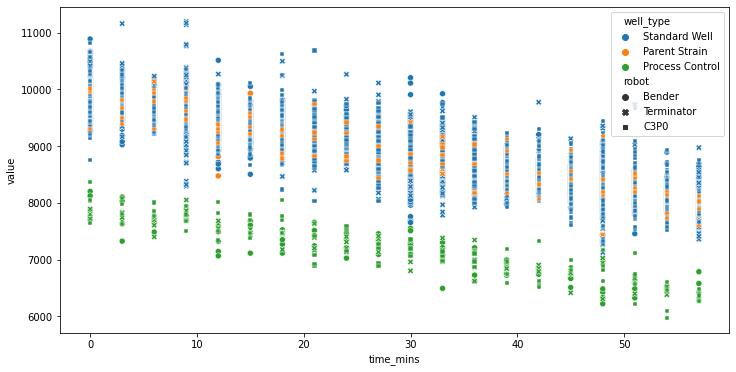

In [104]:
# Plot all, separated by robot and strain type. 
# Let's look at the differences, if maybe we'll detrend then add/subtract means from each

plt.figure(figsize=(12,6))
sns.scatterplot(data = df,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

Wow pretty informative for a first graph! Some of the outliers mentioned in the brief are apparent; I'll discuss these in a second. I think the biggest thing to note is the decreasing trend. The process control should hopefully remain constant throughout the experiment, but it's decreasing over time, suggesting the instrument is becoming less sensitive or whatever's being measured is degrading. The same or similar phenomenon is observed for the standard wells and parent strain.

So: we need to confirm the robots are comparable to be able to pool results, and now we also need to correct for this downward trend. The correct order in which to do so is... not immediately apparent, and I'll discuss below why I chose the route I did, but let's first look at another representation that may be a little more clean: 

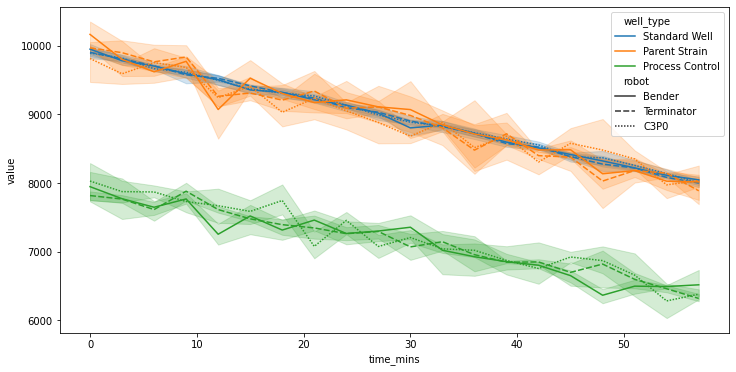

In [105]:
# FIXME MORE DESCRIPTIVE OF LINE PLOT ETC. MAYBE LOOK UP YOUTUBE
# also a line plot, which also helps to visualize a bit:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot
# "By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate."

plt.figure(figsize=(12,6))
sns.lineplot(data = df,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

Still not an exhaustive analysis, but it appears in this plot the robots may have differences that may need to be accounted for or at least acknowledged. What mostly sticks out to me is that at time 12, we see a drop in both the process control and parent strain for Bender. 

But, for the most part...

# That looks good!

Ok, so, we see now that there's a fairly linear downward trend; we can remove that and correct for whatever's happening, molecule getting eaten or instrument inefficiency. And, at least visually, it seems the robots are... fairly comparable. But, just saying that isn't enough... we need to do some statistical analysis.

---


So, with the goal of pooling all our results and having more samples to compare against and increasing our decision-making power, we need to correct for the downward trend over time, and confirm we can pool the robots; or at least account for the error we'll introduce by making these assumptions.

Some initial problems:
- There are a few methods to correct for the downward trend, and I think the most... transparent is to employ a line of best fit and subtract it from each sample. This will then give us the differences from the line of best fit as the value for each sample; a +/- from some predicted value. This line will be affected by outliers. Do we remove them now or when we can more effectively compare outliers against more data? For now I'm going with the latter; I think reproducing the analysis below with the outliers removed may then be of interest to see how much effect they were having.
- Detrend each robot separately, or with the same line of best fit for each well type, thereby assuming we can move forward with the assumption the robots are comparable?

Ultimately, the goal is to compare all X at all times to choose which to move forward with in subsequent screening. So, I'll reiterate below, but I think moving forward with the assumption the robots are comparable, pooling data as much as possible, then removing outliers and confirming our assumption of comparability, will be the most fruitful. 

So:
- Assume robot results comparable, can pool results from each for the different well types
- Fit line of best fit, used to detrend, per well type. This... also needs to be discussed!

---

We'll check the math below also, but the line of best fit will be fit per well type. It all seems so clear from here...

<img src="https://i.pinimg.com/originals/b5/04/cc/b504cc8d7ec95babd00557d8bd72aa00.jpg" width="300" height="400" />

In [106]:
# gotta use this somewhere lol:
# https://i.kym-cdn.com/photos/images/original/001/930/800/8ce.jpg

In [107]:
# FIXME INSERT ANOVA/ASSUMPTIONS GOING FORWARD HERE. ALTHOUGH NONIDEAL... 
# WE GOTTA COMPARE THESE STRAINS LOL

# FIXME!!! ALSO REMOVE OUTLIERS IN THIS STEP WITH ANOVA. LIKE... THROW OUT WHATEVER'S BEYOND
# 3 STDEVS. JUST NOTE THIS DEFINITION. ADD THE ONES >3 STDEVS TO A RESULT DF,
# LIKE, YES THESE ARE SUS BUT POTENTIALLY OF INTEREST!


The plot below is produced by seaborn, which does not feature exposable statistics, so the lines aren't necessarily the same as what'll be calculated with the statmodels package. But, we do get to see that the lines of best fit are fairly parallel and there's a similar linear trend down.

<Figure size 864x432 with 0 Axes>

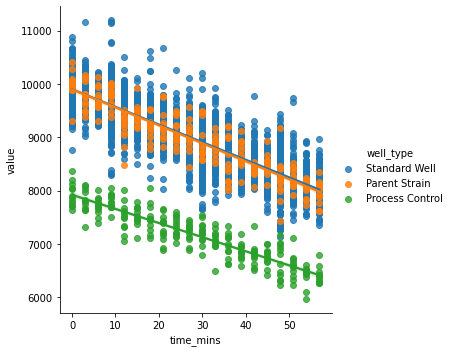

In [108]:
# Seaborn is limited to providing visualization,
# it is not possible to extract regression coefficients from graphs lol
plt.figure(figsize=(12,6))
sns.lmplot(data = df,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                hue = "well_type",
                )

Appear fairly parallel, let's quantify though. The detrending method I'm going with is to subtract the line of best fit. There are alternatives like subtracting a rolling mean, but I think the math and transformation of the data is more opaque using that method. Plus the trend does really look lienar.

I'd like to see how similar these lines come out to be, so we're ideally removing the same trend that appears in the control from PS and X, thereby removing whatever underlying effect is occurring in the control and not some trend that's a real signal from X/PS. 

Reiterating!! The lines of best fit below are made using statmodels, ordinary least squares method, not necessarily equivalent to the seaborn method of drawing the lines above.


In [109]:
# let's see first how the lines fit to PS, PC, and X are. if slope is the same...
# not really anything to adjust
# we'll go one by one, see how well this is really fitting to the data...

# BIG ASS NOTE: SCIPY USES 'LINEAR LEAST SQUARES' AND STATSMODELS USES 'ORDINARY LEAST SQUARES'
# they treat outliers differently... so hopefully our analysis above removed them!

# PC:

pc_data = df[df.well_type == 'Process Control']
# pc_data.describe()

pc_ols = smf.ols('value ~ time_mins', data=pc_data).fit()
print("SUMMARY FOR PC")
print(pc_ols.summary())

SUMMARY FOR PC
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1113.
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           1.07e-91
Time:                        05:20:38   Log-Likelihood:                -1625.7
No. Observations:                 240   AIC:                             3255.
Df Residuals:                     238   BIC:                             3262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7922.4692     26.432    2

Approx m = -26; b = 7900; doubt b matters but let's see if m is approx the same in others. R^2 is... not great, not terrible

In [110]:
ps_data = df[df.well_type == 'Parent Strain']

ps_ols = smf.ols('value ~ time_mins', data=ps_data).fit()
print("SUMMARY FOR PS")
print(ps_ols.summary())

SUMMARY FOR PS
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     1090.
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           8.30e-91
Time:                        05:20:38   Log-Likelihood:                -1686.0
No. Observations:                 240   AIC:                             3376.
Df Residuals:                     238   BIC:                             3383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9897.3872     33.990    2

In [111]:
x_data = df[df.well_type == 'Standard Well']

x_ols = smf.ols('value ~ time_mins', data=x_data).fit()
print("SUMMARY FOR X")
print(x_ols.summary())

SUMMARY FOR X
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 2.054e+04
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        05:20:38   Log-Likelihood:                -37420.
No. Observations:                5280   AIC:                         7.484e+04
Df Residuals:                    5278   BIC:                         7.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9901.1477      7.680   128

In [112]:
pc_data['predicted_value'] = pc_ols.predict(pc_data.time_mins)
pc_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,counter,plate,strain,well_type,robot,stacker_position,value,time_mins,predicted_value
92,93,1,Y0001,Process Control,Bender,1,8201.149131,0,7922.469212
93,94,1,Y0001,Process Control,Bender,1,7703.484788,0,7922.469212
94,95,1,Y0001,Process Control,Bender,1,7761.724704,0,7922.469212
95,96,1,Y0001,Process Control,Bender,1,8122.782322,0,7922.469212
188,189,2,Y0001,Process Control,Bender,2,8102.489627,3,7843.127112


In [113]:
# sexy ONE line solution, DO NOT. DO NOT FORGET THE AXIS=1, informs pandas to look for a column when referencing x
pc_data['detrended_value'] = pc_data.apply(lambda x: x['value'] - x['predicted_value'], axis = 1)

pc_data.head()

# OK!!! finally

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,counter,plate,strain,well_type,robot,stacker_position,value,time_mins,predicted_value,detrended_value
92,93,1,Y0001,Process Control,Bender,1,8201.149131,0,7922.469212,278.679919
93,94,1,Y0001,Process Control,Bender,1,7703.484788,0,7922.469212,-218.984424
94,95,1,Y0001,Process Control,Bender,1,7761.724704,0,7922.469212,-160.744508
95,96,1,Y0001,Process Control,Bender,1,8122.782322,0,7922.469212,200.313110
188,189,2,Y0001,Process Control,Bender,2,8102.489627,3,7843.127112,259.362514


In [114]:
# same thing for the other dataframes. hope the math is clear atm!
# PS:
ps_data['predicted_value'] = ps_ols.predict(ps_data.time_mins)
ps_data['detrended_value'] = ps_data.apply(lambda x: x['value'] - x['predicted_value'], axis = 1)
# X:
x_data['predicted_value'] = x_ols.predict(x_data.time_mins)
x_data['detrended_value'] = x_data.apply(lambda x: x['value'] - x['predicted_value'], axis = 1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [115]:
x_data.describe() # IT WORKED!

,counter,plate,stacker_position,value,time_mins,predicted_value,detrended_value
count,5280.000000,5280.000000,5280.000000,5280.000000,5280.000000,5280.000000,5.280000e+03
mean,2876.500000,30.500000,10.500000,8960.237927,28.500000,8960.237927,3.019075e-12
std,1662.889342,17.319742,5.766827,640.361179,17.300482,571.164657,2.895399e+02
min,1.000000,1.000000,1.000000,7125.219488,0.000000,8019.328162,-1.651311e+03
25%,1438.750000,15.750000,5.750000,8456.581356,14.250000,8489.783044,-1.593694e+02
50%,2876.500000,30.500000,10.500000,8952.667777,28.500000,8960.237927,-7.125661e+00
75%,4314.250000,45.250000,15.250000,9462.720736,42.750000,9430.692810,1.567165e+02
max,5752.000000,60.000000,20.000000,11193.991178,57.000000,9901.147692,1.589973e+03


In [116]:
# Now let's bring the band back together and visualize again. THEN, FINALLY...
# we'll have a detrended dataset and can do some proper analysis
# what a mess lololol

# d for detrended... might change this later
d_df = pc_data
d_df = d_df.append(ps_data)
d_df = d_df.append(x_data)


In [117]:
d_df.describe()

,counter,plate,stacker_position,value,time_mins,predicted_value,detrended_value
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5.760000e+03
mean,2880.500000,30.500000,10.500000,8884.673853,28.500000,8884.673853,2.719958e-12
std,1662.913107,17.319606,5.766782,729.209775,17.300346,670.783243,2.860013e+02
min,1.000000,1.000000,1.000000,5969.815929,0.000000,6414.969312,-1.651311e+03
25%,1440.750000,15.750000,5.750000,8384.141743,14.250000,8415.500694,-1.577005e+02
50%,2880.500000,30.500000,10.500000,8907.513168,28.500000,8910.716360,-5.998895e+00
75%,4320.250000,45.250000,15.250000,9442.721749,42.750000,9405.932026,1.556465e+02
max,5760.000000,60.000000,20.000000,11193.991178,57.000000,9901.147692,1.589973e+03


DOPE! Back to 5760 counter, mean for detrended value is effectively 0. Let's VISUALIZEEEEEE

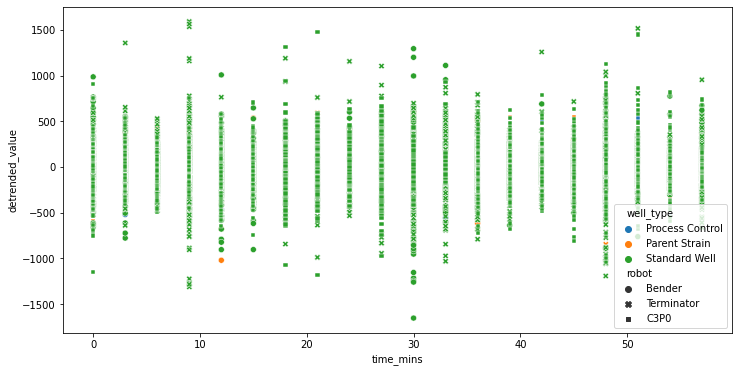

In [126]:
plt.figure(figsize=(12,6))
sns.scatterplot(data = d_df,                
                # literally x and y axes
                x='time_mins',
                y='detrended_value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

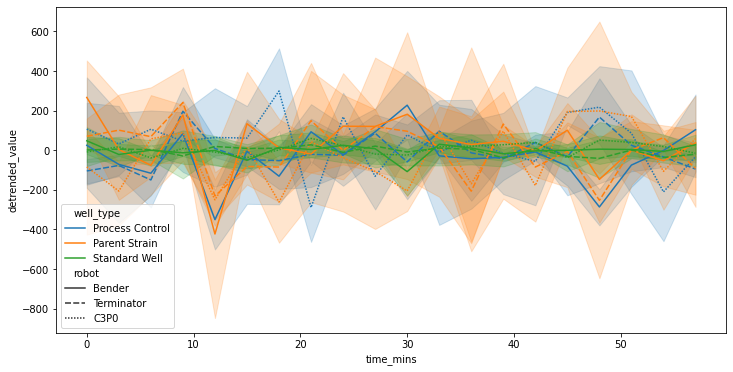

In [127]:
plt.figure(figsize=(12,6))
sns.lineplot(data = d_df,                
                # literally x and y axes
                x='time_mins',
                y='detrended_value',
                # grouping variables:
                hue = "well_type",
                style = "robot",
                # legend = 'auto', # auto by default
                )

Alright, looks like it worked!!!! :)))))

We now have completed that first step 1, detrending the data. Whew. 

Now, again seaborn isn't a substitute for later analysis, but global mean is about 0. And looking at the confidence intervals that seaborn drew, there is not a uniform spread of the data for the different well types.

This is of interest, because the next steps involve the mean and comparing distributions, at least as I'm analyzing this. Those next steps are:

1. Confirm that robot hypothesis or see extent of difference in distributions. The mean now artifically is at 0, but we can properly compare the distributions of the process control from different robots and see how large the standard deviation is. I'm thinking we make the largest stdev the minimum stdev we assume in X.... Anyway, this is ANOVA between different process control results from the different robots.

2. Compare the X and PS populations; a t-test. Take the top n% p < 0.05 or w/e from X versus PS.

3. Also clean stuff up, remove outliers beyond 3 stdev, following the rule from 1. If... interested, re-do the line fitting and see the extent of the difference. Add those outliers to a dataframe; identify the highly positive ones as of interest, could be not a fluke.

---
---
---

So, this is one strategy we could of used to do the ANOVA for the extent of deviation in the process control. An alternative would of been to regard the process control with a repeated measure ANOVA, which we could still do, and see how the variation changed over time... could still do! But now technically we've made our results independent of time and can compare. So let's do regular ANOVA first and then compare with the repeated measure ANOVA -- which if we applied to the original dataset requires moving averages etc.


In [128]:
# alright, going in with the goal of just getting the stdev of ea. distribution,
# comparing that since all the means will definitely be the same.

# looking into it I like the scipy implementation better in this case;
# documentation for scipy and statsmodels:
# https://www.statsmodels.org/dev/anova.html
# https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
# https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.f_oneway.html




BUT WAIT! ANOVA assumes homoscedacity. We literally have to assume that the stdev of all groups are the same. And we've now forced the means to all be the same... hmmmm. HAVE WE???? Yes.

The stdev are all pretty equal. The means don't appear too different, +/- 10. So... yeah, let's do ANOVA again. Idk if detrending

---

Ok, so let's say we went back and did the repeated measure ANOVA at the beginning, when the means were not necessarily == . Still the same homoscedacity assumption. And ultimately we MUST do the detrending in order to properly compare the X's. 

So... a futile exercise! All we really can do is just get the stdev's of ea group. Let's see if there's something we can do with that.

In [142]:
# alright so we gotta divvy this shit up by the robit

#df[df.well_type == 'Parent Strain'].std() # pretty neat this shit fuckign works
d_df[d_df.robot == 'Bender'].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


counter             554.400577
plate                 5.767784
stacker_position      5.767784
value               722.996363
time_mins            17.303351
predicted_value     670.899749
detrended_value     263.149760
dtype: float64

In [144]:
d_df[d_df.robot == 'C3P0'].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


counter             554.400577
plate                 5.767784
stacker_position      5.767784
value               718.699054
time_mins            17.303351
predicted_value     670.899749
detrended_value     285.910106
dtype: float64

In [145]:
d_df[d_df.robot == 'Terminator'].std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


counter             554.400577
plate                 5.767784
stacker_position      5.767784
value               745.971850
time_mins            17.303351
predicted_value     670.899749
detrended_value     307.269048
dtype: float64

Yeah so homoscedacitiy assumption seems pretty valid, we see 718 to 745 stdev between robots for value. Now, ideally this would be 0 and we'd always be measuring some real value. 

But, anyway the number of interest for subsequent analyses is that 263-307, the detrended value's stdev. Outliers are defined as outside 3 stdev's usually. So assuming highest stdev, we'd expect outliers approx. >900, +/- for the control. Do we see that?

In [137]:
d_df[d_df.well_type == 'Process Control'].describe()

,counter,plate,stacker_position,value,time_mins,predicted_value,detrended_value
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02
mean,2926.500000,30.500000,10.500000,7168.719262,28.500000,7168.719262,2.808065e-12
std,1666.012678,17.354295,5.778332,505.118546,17.334996,458.465000,2.120250e+02
min,93.000000,1.000000,1.000000,5969.815929,0.000000,6414.969312,-5.566123e+02
25%,1509.750000,15.750000,5.750000,6784.351269,14.250000,6791.844287,-1.262062e+02
50%,2926.500000,30.500000,10.500000,7173.294809,28.500000,7168.719262,5.696354e+00
75%,4343.250000,45.250000,15.250000,7563.393400,42.750000,7545.594237,1.357696e+02
max,5760.000000,60.000000,20.000000,8373.677376,57.000000,7922.469212,6.017727e+02


No, we don't see outliers in the control's detrended values. Woop! Min -556, max 601, both less than the 900. Ok. So... this just informs the floor for outliers, likely will be greater stdev for the parent and candidate strains, and therefore, at least given this info, we'll only need to re-fit for not the process control if we want to in the future. 


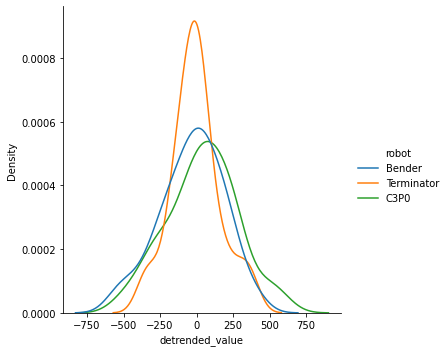

In [146]:
###############
# OVERLAY HISTOGRAMS OR SOME GRAPH OF DISTS TO SEE THIS!!! PRROOOOOOVEEE IT
#############
sns.displot(data = d_df[d_df.well_type == 'Process Control'],
            x = "detrended_value",
            hue = 'robot',
            kind = 'kde'
)

Seems like Terminator is the most consistent... for now... if you get another robot, I'd recommend stopping at Terminator 2. Anyway, despite the difference in stdev, seem fairly similar; aritfically at mean = 0, so that's not valuable. We'll better be able to assess how this informs results when we look at PS/X below.

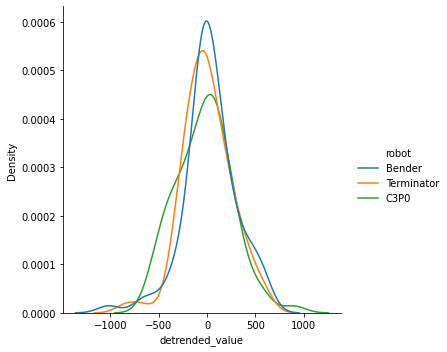

In [147]:
sns.displot(data = d_df[d_df.well_type == 'Parent Strain'],
            x = "detrended_value",
            hue = 'robot',
            kind = 'kde'
)

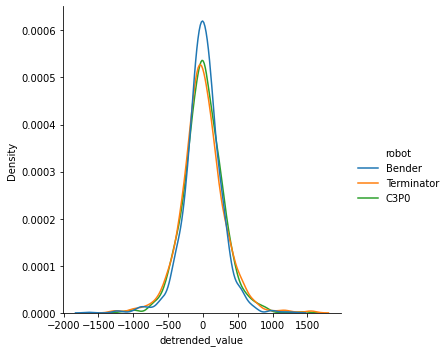

In [148]:
sns.displot(data = d_df[d_df.well_type == 'Standard Well'],
            x = "detrended_value",
            hue = 'robot',
            kind = 'kde'
)

Yeah, way crazier! I'll also put all these up again in a sec to compare each other. But, parent strain serves somewhat as a second control, and we see the candidate strains very much have greater spread. Many could be outliers and experimental oopsies, but, anyway we'll keep track of the positive ones as super-duper candidates.

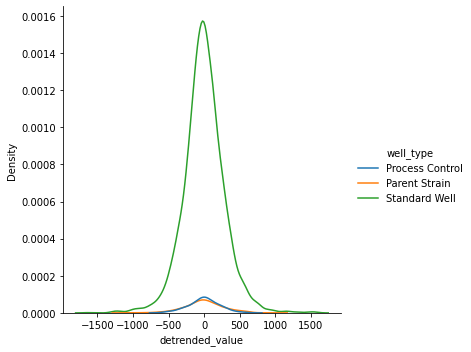

In [149]:
sns.displot(data = d_df,#[d_df.well_type == 'Standard Well'],
            x = "detrended_value",
            hue = 'well_type',
            kind = 'kde'
)

Can definitely better see the spread here. FIXME: look into some scaling thing with the obvious huge pop. Or different graph altogether.

---

Anyway. For my next trick we'll do Welch's!!! ... Which...
Is it appropriate? Technically, for each candidate strain, it'll have the mean... of whatever the heck its value is. So as long as it's greater than 95% of the values in the parent strain, it's gonna reject the null hypothesis. There is no POPULATION to actually compare.

... So. Let's look into single sample procedures... but um... cheating a bit, let's look into how many samples are above 95% of the parent strain.

In [163]:
d_df[d_df.well_type == 'Parent Strain'].quantile(.99) # greater than 508 is our cutoff I guess

counter              5753.610000
plate                  60.000000
stacker_position       20.000000
value               10158.763760
time_mins              57.000000
predicted_value      9897.387220
detrended_value       590.511938
Name: 0.99, dtype: float64

In [165]:
# d_df[(d_df.well_type == 'Standard Well'.detrended_value > 508)]\\
qq = d_df[d_df.well_type == 'Standard Well']
bigq = qq[(qq.detrended_value > 600)]# and d_df.well_type == 'Standard Well#')]
bigq.describe()
# results in like 210 recommendations; they ask for 20, 30 180 etc. so let's see 99th percentile
# 124 at > 600

# df[(df > threshold).any(1)]

,counter,plate,stacker_position,value,time_mins,predicted_value,detrended_value
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,3253.475806,34.419355,11.193548,9709.585009,30.580645,8891.546722,818.038287
std,1622.422446,16.878859,5.848601,649.876685,17.545804,579.263795,236.487058
min,10.000000,1.000000,1.000000,8640.344270,0.000000,8019.328162,601.158617
25%,2219.750000,24.000000,6.000000,9128.178671,15.000000,8316.457561,657.167332
50%,3105.500000,33.000000,12.000000,9612.593756,33.000000,8811.673227,736.725104
75%,4782.500000,50.000000,17.000000,10253.164700,48.000000,9405.932026,891.081327
max,5717.000000,60.000000,20.000000,11193.991178,57.000000,9901.147692,1589.972886


<img src="https://y.yarn.co/652a8aa6-b8fc-4d0c-88c8-74c1ed237e96_text.gif" width="400" height="300" />

In [ ]:
# Ok. So, just... SOME t-test, with single samples just to confirm. But looking
# at parent strain's > 0.99 percentile, we got like 100 fuckers to promote.
# so. Do that test just cuz. But then yeah... after that... pfffff...
# I think removing or flagging outliers. ummm. veryifying the t-test math.
# anova on the controls anyway. statistically prove we gucci. and also do it on these 3 pops,
# why not? just to have the number. figure it out with scipy, kinda gets funky

# DEF REMOVE OUTLIERS. LOOK AT THAT FUCK, 12K AT THE VERY END. DEF FLAGGGGG
# BUT OTHERWISE YEAH I THINK THE .99 PERCENTILE ETC. MUCHO GUCCI

# if interested in plotting specifically the statsmodels thing:
# https://stackoverflow.com/questions/42261976/how-to-plot-statsmodels-linear-regression-ols-cleanly


---

Issue here though. The detrending process forces all means to 0. And ANOVA at least assumes homoscedacity...

Does the t-test? And did we successfully set those means to 0? We can check the latter. Welch's t-test doesn't assume homoscedacity, so let's apply that in this analysis. 

---

The detrending choice is seeming problematic. But. Really it allows us to just... pluck the top results here. And likely it seems there will be much greater stdev in the candidate strains than the parent strain, so. Yes. Welch's. 

<img src="https://www.riteaid.com/shop/media/catalog/product/l/v/lvqg2n9ajffapci0szic.jpg?quality=80&bg-color=255,255,255&fit=bounds&height=406&width=406&canvas=406:406" width="300" height="400" />

Still hits.

# Old mierda a bajo...

SO, X (standard wells) and PS (parent strain) have roughly same trend. Actually kind of surprising given the outliers we saw above for X, which very much ARE influencing this result.

PC (process control) is different, either due to outliers, instrument error, and/or different phenomena affecting the results.

We see therefore this detrending method is not perfect, but affords some ability to confirm the detrending being done to the different populations. 

I think there's a few interpretations to go forward with:

1. Remove the trend only seen in the control; this will leave a nonzero trend in PS and X

2. Remove each group's trend. Without more knowledge of the control, this seems more appropriate. The phenomena in the control may not completely reflect PS/X. Could be a combination of instrument inefficiency AND e.g. enzymatic degradation. 

3. Linear trend not appropriate. It doesn't look like quadratic/polynomial/exponential will be appropriate either based on shape seen above in the linear plot, but this could be examined in future work or if I got some extra time!

Therefore going forward with #2, detrending each data stream respectively, not just subtracting the control. The goal is still to be able to most easily compare the X population, and so using the line of best fit calculated for that seems best. We can use stats from the control to inform analysis in some further steps.

In [118]:
pc_data.head()

,counter,plate,strain,well_type,robot,stacker_position,value,time_mins,predicted_value,detrended_value
92,93,1,Y0001,Process Control,Bender,1,8201.149131,0,7922.469212,278.679919
93,94,1,Y0001,Process Control,Bender,1,7703.484788,0,7922.469212,-218.984424
94,95,1,Y0001,Process Control,Bender,1,7761.724704,0,7922.469212,-160.744508
95,96,1,Y0001,Process Control,Bender,1,8122.782322,0,7922.469212,200.313110
188,189,2,Y0001,Process Control,Bender,2,8102.489627,3,7843.127112,259.362514


There is an option to use a detrend method in scipy, that applies a 'linear lines of best fit' rather than the 'ordinary lines of best fit' in statmodels. I'm not sure how much the difference is in this context, but scipy also doesn't easily expose relevant statistics. So we'll manually do the detrending with the statmodels... models, and create a new feature. Better traceability altogether.

In [119]:
# use the lambda function to create new features for each thing...
# maybe just write a whole function to go per 'well-type'
# be fancy shamnsy

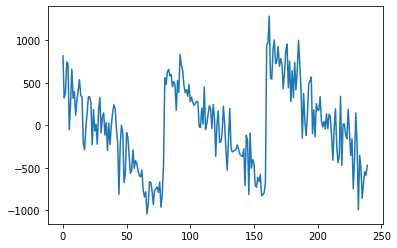

In [120]:
# Using scipy: Subtract the line of best fit
# from scipy import signal
detrended = signal.detrend(pc_data['value'])
plt.plot(detrended) #wtffff?????
# plt.title('Air Passengers detrended by subtracting the least squares fit', fontsize=16)

In [121]:
# new = old[['A', 'C', 'D']].copy()
super = pc_data[['time_mins','value']].copy()

In [122]:
super.head()

,time_mins,value
92,0,8201.149131
93,0,7703.484788
94,0,7761.724704
95,0,8122.782322
188,3,8102.489627


In [123]:
super.value = signal.detrend(super)
# dpc.value = signal.detrend(dpc.value) #signal.detrend writes immediately to what it is fed

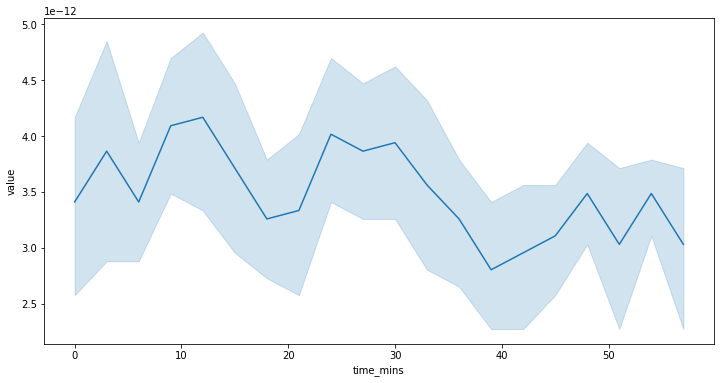

In [124]:
# FIXME MORE DESCRIPTIVE OF LINE PLOT ETC. MAYBE LOOK UP YOUTUBE
# also a line plot, which also helps to visualize a bit:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot
# "By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate."

plt.figure(figsize=(12,6))
sns.lineplot(data = super,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                # hue = "well_type",
                # style = "robot",
                # legend = 'auto', # auto by default
                )

In [125]:
# FIXME MORE DESCRIPTIVE OF LINE PLOT ETC. MAYBE LOOK UP YOUTUBE
# also a line plot, which also helps to visualize a bit:
# https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot
# "By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate."

plt.figure(figsize=(12,6))
sns.lineplot(data = dpc,                
                # literally x and y axes
                x='time_mins',
                y='value',
                # grouping variables:
                # hue = "well_type",
                # style = "robot",
                # legend = 'auto', # auto by default
                )

NameError: ignored

<Figure size 864x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(pc_data.time_mins, pc_data.value, label="pc_og")
# plt.plot(dpc.time_mins, dpc.value, label="pc_detrended")
plt.legend(loc='best')
plt.show()

Plotting the process controls over time, 3 lines, 1 per robot.

Objective: observe the variation per measurement of PC, per robot. ideally, data from different robots can be reliably compared.

box and whisker or just scatter plot w. mean and stdev, t-series with stack position as
time marker. Can also data transform for minutes into experiment, probably better
to have that direct measurement to qualify.

In [ ]:
# feature transform, the stack position -> experiment time

In [ ]:
# sns plot, filter for process control, time-series scatter plot,
# overlay stdev and mean and 1 line per robot. observe variation in method

In [ ]:
###############
# CACA for the subtraction
#

# options to implement adding detrended values:
# 1. use dict and if's per value
# 2. lambda on 3 dfs above, then merge... this seems less elegant but easier to implement lol
# df['detrended_value'] = df['value'].apply(lambda x:
#                                             if df['well_type'] == 'Process Control':
#                                               x = x - pc_ols.predict(x)
#                                             else:
#                                               True
# )

# pc_data = df[df.well_type == 'Process Control']
# # pc_data.describe()

# pc_ols = smf.ols('value ~ time_mins', data=pc_data).fit()
# print("SUMMARY FOR PC")
# print(pc_ols.summary())
# q = pc_ols.predict(pc_data.value)


# Okie, this is annoying but doable. have to subtrat predicted_value from value. 
# the lambda function for this is sus, so gonna use...

# better than below:

# def simpleSubtraction(x):
#   return x['value'] - x['predicted_value']

# pc_data.apply(simpleSubtraction, axis=1)


# def simpleSubtraction(df):
#   # remover = SaltRemover(defnData="[Cl,Br,Zn,Mg,Ca,Sr,Na,K]")
#   for index, row in df.iterrows():
#     value = row['value'] # WELCOME TO THE CIRCUS OF VALUE
#     pred_value = row['predicted_value']
#     detrended_value = value - pred_value

    # alright, as far as I know now we gotta build a dict to return a new df. not my fav implementation

    # pc_data['value_detrended'] = pc_data['value'].apply(lambda x: x - pc_ols.predict(x))

# df['time_mins'] = df['stacker_position'].apply(lambda x: 3*x-3) 
# or maybe both oooOOooo
